**Investigating Community Detection**

Gian Favero | ECSE 556 | December 1st, 2023

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from helpers import *

First we load the .edge file associated with the “HumanNet Co-Expression of Human Genes (hn_HS_CX) network. The file will be cleaned up in such a way that only the relevant columns and values are kept.

In [5]:
edges_df = pd.read_csv('9606.hn_HS_CX.edge', sep='\t', header=None)
edges_df = edges_df.iloc[:, :3]
edges_df.columns = ['Node 1', 'Node 2', 'Weight']
print(edges_df.head())

            Node 1           Node 2    Weight
0  ENSG00000284589  ENSG00000276821  0.000008
1  ENSG00000284589  ENSG00000267534  0.000006
2  ENSG00000284589  ENSG00000178802  0.000006
3  ENSG00000284589  ENSG00000172772  0.000007
4  ENSG00000284589  ENSG00000167751  0.000008


Now we have to start forming the adjacency matrix that represents the network. We can get a set of every node in the network and then augment the dataset to ensure the network is undirected.

In [6]:
# Get set of all nodes
nodes = set(edges_df['Node 1'])
nodes = nodes.union(set(edges_df['Node 2']))

print('Number of nodes:', len(nodes))
print('Number of edges:', len(edges_df))

# Convert nodes to indices in edges_df
nodes_dict = dict(zip(nodes, range(len(nodes))))
edge_id_df = edges_df.copy()
edge_id_df['Node 1'] = edge_id_df['Node 1'].map(nodes_dict)
edge_id_df['Node 2'] = edge_id_df['Node 2'].map(nodes_dict)

# Initialize adjacency matrix
adj_mat = np.zeros((len(nodes), len(nodes)))

# Fill adjacency matrix
for i in tqdm(range(len(edge_id_df))):
    row = edge_id_df.iloc[i]
    adj_mat[int(row['Node 1']), int(row['Node 2'])] = row['Weight']

# If there are any self-loops, remove them
np.fill_diagonal(adj_mat, 0)

Number of nodes: 10938
Number of edges: 154387


100%|██████████| 154387/154387 [00:12<00:00, 12189.83it/s]


In [7]:
# Adjust adjacency matrix to be symmetric, undirected
adj_mat = process_symmetric_entries(adj_mat)

# Find all subgraphs and get list of nodes that belong to subgraphs with less than 5 nodes
subgraphs = find_subgraphs(adj_mat)
nodes_remove = nodes_to_remove(subgraphs, 5)

# Remove nodes from adjacency matrix
adj_mat = np.delete(adj_mat, nodes_remove, axis=0)
adj_mat = np.delete(adj_mat, nodes_remove, axis=1)

# Remove nodes from nodes list
nodes = list(nodes)
nodes = [nodes[i] for i in range(len(nodes)) if i not in nodes_remove]
nodes_dict = dict(zip(nodes, range(len(nodes))))

# Remove rows from edges_df that contain nodes that were removed
edges_df = edges_df[edges_df['Node 1'].isin(nodes)]
edges_df = edges_df[edges_df['Node 2'].isin(nodes)]

edges_df['Node 1'] = edges_df['Node 1'].map(nodes_dict)
edges_df['Node 2'] = edges_df['Node 2'].map(nodes_dict)

# Normalize adjacency matrix by row
tr_mat = adj_mat / adj_mat.sum(axis=1, keepdims=True)

# Print size of network
print('Number of nodes: ', len(nodes))
print('Number of edges: ', len(edges_df))

# Choose 5000 random nodes to remove from network
nodes_remove = np.random.choice(range(len(nodes)), size=10325, replace=False)

# Remove nodes from adjacency matrix
adj_mat = np.delete(adj_mat, nodes_remove, axis=0)
adj_mat = np.delete(adj_mat, nodes_remove, axis=1)

Number of nodes:  10825
Number of edges:  154328


**Community Detection**

Using the same network, we can perform a community detection with various algorithms.

In [8]:
import networkx as nx
import community as community_louvain
from networkx.algorithms import community

import pickle

# Define graph
G = nx.from_numpy_matrix(adj_mat)

# Apply Clauset-Newman-Moore algorithm
clauset_newman_communities = list(community.greedy_modularity_communities(G))
clauset_newman_clusters = {f'Community_{i+1}': list(community_set) for i, community_set in enumerate(clauset_newman_communities)}

# Apply Louvain algorithm
partition = community_louvain.best_partition(G)
louvain_clusters = {f'Community_{i+1}': [node for node, community_id in partition.items() if community_id == i] for i in set(partition.values())}

# Apply Girvan-Newman algorithm
girvan_newman_communities = next(community.girvan_newman(G))
girvan_newman_clusters = {f'Community_{i+1}': list(community_set) for i, community_set in enumerate(girvan_newman_communities)}

# Save the clusters to a dictionary
all_clusters = {
    'Clauset_Newman_Moore': clauset_newman_clusters,
    'Louvain': louvain_clusters,
    'Girvan_Newman': girvan_newman_clusters
}

# Save the dictionary to a pickle file
with open('community_clusters.pkl', 'wb') as file:
    pickle.dump(all_clusters, file)

print("Community clusters saved to 'community_clusters.pkl'")

Community clusters saved to 'community_clusters.pkl'


In [68]:
import matplotlib.pyplot as plt
import pickle

def get_num_edges_between_clusters(clusters, adj_mat):
    num_edges_between_clusters = {}
    for cluster_1 in clusters:
        for cluster_2 in clusters:
            if cluster_1 != cluster_2:
                edges = adj_mat[np.ix_(clusters[cluster_1], clusters[cluster_2])]
                num_edges_between_clusters[(cluster_1, cluster_2)] = np.sum(edges)
    return num_edges_between_clusters

def get_pair_with_fewest_edges_between_clusters(num_edges_between_clusters):
    return min(num_edges_between_clusters, key=num_edges_between_clusters.get)

def merge_clusters(clusters, cluster_1, cluster_2):
    merged_cluster = clusters[cluster_1] + clusters[cluster_2]
    del clusters[cluster_1]
    del clusters[cluster_2]
    clusters[f'Merged_{cluster_1}_{cluster_2}'] = merged_cluster
    return clusters

# Load the clusters from the pickle file
with open('community_clusters.pkl', 'rb') as file:
    all_clusters = pickle.load(file)

greedy_clusters = all_clusters['Clauset_Newman_Moore']
louvain_clusters = all_clusters['Louvain']
girvan_newman_clusters = all_clusters['Girvan_Newman']

# Print the number of clusters for each algorithm
print('Number of clusters for Clauset-Newman-Moore:', len(greedy_clusters))
print('Number of clusters for Louvain:', len(louvain_clusters))
print('Number of clusters for Girvan-Newman:', len(girvan_newman_clusters))

clusters = 5

# Merge clusters until there are only 5 clusters left
while len(greedy_clusters) > clusters:
    num_edges_between_clusters = get_num_edges_between_clusters(greedy_clusters, adj_mat)
    cluster_1, cluster_2 = get_pair_with_fewest_edges_between_clusters(num_edges_between_clusters)
    greedy_clusters = merge_clusters(greedy_clusters, cluster_1, cluster_2)

while len(louvain_clusters) > clusters:
    num_edges_between_clusters = get_num_edges_between_clusters(louvain_clusters, adj_mat)
    cluster_1, cluster_2 = get_pair_with_fewest_edges_between_clusters(num_edges_between_clusters)
    louvain_clusters = merge_clusters(louvain_clusters, cluster_1, cluster_2)

while len(girvan_newman_clusters) > clusters:
    num_edges_between_clusters = get_num_edges_between_clusters(girvan_newman_clusters, adj_mat)
    cluster_1, cluster_2 = get_pair_with_fewest_edges_between_clusters(num_edges_between_clusters)
    girvan_newman_clusters = merge_clusters(girvan_newman_clusters, cluster_1, cluster_2)

# Get the number of clusters for each algorithm
greedy_num_clusters = len(greedy_clusters)
louvain_num_clusters = len(louvain_clusters)
girvan_newman_num_clusters = len(girvan_newman_clusters)

Number of clusters for Clauset-Newman-Moore: 295
Number of clusters for Louvain: 294
Number of clusters for Girvan-Newman: 286
Number of nodes in each cluster for Clauset-Newman-Moore:
Merged_Merged_Merged_Merged_Merged_Community_271_Community_272_Merged_Community_273_Community_274_Merged_Merged_Community_275_Community_276_Merged_Community_277_Community_278_Merged_Merged_Merged_Community_279_Community_280_Merged_Community_281_Community_282_Merged_Merged_Community_283_Community_284_Merged_Community_285_Community_286_Merged_Merged_Merged_Merged_Community_287_Community_288_Merged_Community_289_Community_290_Merged_Merged_Community_291_Community_292_Merged_Community_293_Community_294_Merged_Merged_Merged_Community_295_Merged_Community_1_Community_2_Merged_Merged_Community_8_Community_11_Merged_Community_17_Community_18_Merged_Merged_Merged_Community_31_Community_32_Merged_Community_33_Community_34_Merged_Merged_Community_35_Community_36_Merged_Community_37_Community_38: 114
Merged_Merged_M

Visualization

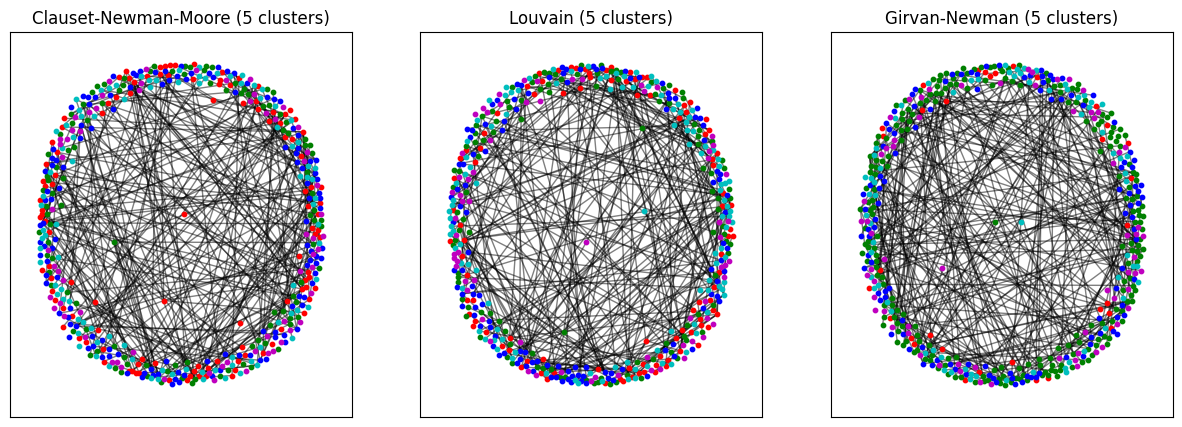

In [69]:
# Plot the nx graph with the clusters for each algorithm
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the Clauset-Newman-Moore graph
ax = axes[0]
ax.set_title(f'Clauset-Newman-Moore ({greedy_num_clusters} clusters)')
pos = nx.spring_layout(G)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i, community in enumerate(greedy_clusters.values()):
    color = colors[i % len(colors)]
    nx.draw_networkx_nodes(G, pos, community, ax=ax, node_size=10, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

# Plot the Louvain graph
ax = axes[1]
ax.set_title(f'Louvain ({louvain_num_clusters} clusters)')
pos = nx.spring_layout(G)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i, community in enumerate(louvain_clusters.values()):
    color = colors[i % len(colors)]
    nx.draw_networkx_nodes(G, pos, community, ax=ax, node_size=10, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

# Plot the Girvan-Newman graph
ax = axes[2]
ax.set_title(f'Girvan-Newman ({girvan_newman_num_clusters} clusters)')
pos = nx.spring_layout(G)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i, community in enumerate(girvan_newman_clusters.values()):
    color = colors[i % len(colors)]
    nx.draw_networkx_nodes(G, pos, community, ax=ax, node_size=10, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

Jaccard Similarities

In [70]:
from sklearn.metrics import jaccard_score
import numpy as np

# Convert clusters to binary vectors
def clusters_to_binary_vectors(clusters, num_nodes):
    binary_vectors = []
    for cluster in clusters:
        vector = [0] * num_nodes
        for node in cluster:
            vector[node] = 1
        binary_vectors.append(vector)
    return binary_vectors

# Calculate Jaccard similarity matrix for two algorithms
def get_jaccard_similarity_matrix(binary_vectors_1, binary_vectors_2):
    jaccard_similarity_matrix = np.zeros((len(binary_vectors_1), len(binary_vectors_2)))
    for i, vector_1 in enumerate(binary_vectors_1):
        for j, vector_2 in enumerate(binary_vectors_2):
            jaccard_similarity_matrix[i, j] = jaccard_score(vector_1, vector_2)

    # return matrix as a dataframe
    jaccard_similarity_matrix = pd.DataFrame(jaccard_similarity_matrix)

    return jaccard_similarity_matrix

# Get the binary vectors for each algorithm
num_nodes = adj_mat.shape[0]
greedy_binary_vectors = clusters_to_binary_vectors(greedy_clusters.values(), num_nodes)
louvain_binary_vectors = clusters_to_binary_vectors(louvain_clusters.values(), num_nodes)
girvan_newman_binary_vectors = clusters_to_binary_vectors(girvan_newman_clusters.values(), num_nodes)

# Get the Jaccard similarity matrices for each pair of algorithms
greedy_louvain_jac = get_jaccard_similarity_matrix(greedy_binary_vectors, louvain_binary_vectors)
greedy_girvan_newman_jac = get_jaccard_similarity_matrix(greedy_binary_vectors, girvan_newman_binary_vectors)
louvain_girvan_newman_jac = get_jaccard_similarity_matrix(louvain_binary_vectors, girvan_newman_binary_vectors)

# Print the Jaccard similarity matrices
print('Clauset-Newman-Moore vs. Louvain')
print(greedy_louvain_jac)
print('\nClauset-Newman-Moore vs. Girvan-Newman')
print(greedy_girvan_newman_jac)
print('\nLouvain vs. Girvan-Newman')
print(louvain_girvan_newman_jac)

Clauset-Newman-Moore vs. Louvain
          0         1         2         3         4
0  0.292683  0.027149  0.152284  0.131313  0.022727
1  0.030457  0.513889  0.043062  0.080402  0.000000
2  0.173684  0.081818  0.329609  0.068182  0.000000
3  0.032609  0.078947  0.078947  0.355705  0.019355
4  0.031847  0.000000  0.000000  0.000000  0.830986

Clauset-Newman-Moore vs. Girvan-Newman
          0         1         2         3         4
0  0.204918  0.225455  0.103960  0.011050  0.022727
1  0.000000  0.167260  0.312883  0.041916  0.000000
2  0.000000  0.208333  0.164179  0.197531  0.000000
3  0.000000  0.206897  0.020305  0.210526  0.039474
4  0.089888  0.000000  0.000000  0.000000  0.756757

Louvain vs. Girvan-Newman
          0         1         2         3         4
0  0.271845  0.268775  0.009756  0.000000  0.000000
1  0.006897  0.217391  0.283237  0.016760  0.000000
2  0.000000  0.195730  0.121212  0.229730  0.000000
3  0.007042  0.136519  0.183784  0.217687  0.017341
4  0.031250  0.0

Rand Indices

In [41]:
from sklearn.metrics import adjusted_rand_score, rand_score

def change_keys_to_cluster_id(clusters):
    new_clusters = {}
    for i, cluster in enumerate(clusters.values()):
        new_clusters[i] = cluster
    return new_clusters

# Change the keys of the cluster dicts to be the cluster ID
greedy_id_clusters = change_keys_to_cluster_id(greedy_clusters)
louvain_id_clusters = change_keys_to_cluster_id(louvain_clusters)
girvan_newman_id_clusters = change_keys_to_cluster_id(girvan_newman_clusters)

# Change the dicts to a list in which the index is the node ID and the value is the cluster ID
greedy_rand_clusters = np.zeros(adj_mat.shape[0])
louvain_rand_clusters = np.zeros(adj_mat.shape[0])
girvan_newman_rand_clusters = np.zeros(adj_mat.shape[0])

for cluster_id, cluster in greedy_id_clusters.items():
    for node in cluster:
        greedy_rand_clusters[node] = cluster_id

for cluster_id, cluster in louvain_id_clusters.items():
    for node in cluster:
        louvain_rand_clusters[node] = cluster_id

for cluster_id, cluster in girvan_newman_id_clusters.items():
    for node in cluster:
        girvan_newman_rand_clusters[node] = cluster_id

# Calculate the Rand index for each pair of algorithms
greedy_louvain_rand = rand_score(greedy_rand_clusters, louvain_rand_clusters)
greedy_girvan_newman_rand = rand_score(greedy_rand_clusters, girvan_newman_rand_clusters)
louvain_girvan_newman_rand = rand_score(louvain_rand_clusters, girvan_newman_rand_clusters)

# Calculate the adjusted Rand index for each pair of algorithms
greedy_louvain_adjusted_rand = adjusted_rand_score(greedy_rand_clusters, louvain_rand_clusters)
greedy_girvan_newman_adjusted_rand = adjusted_rand_score(greedy_rand_clusters, girvan_newman_rand_clusters)
louvain_girvan_newman_adjusted_rand = adjusted_rand_score(louvain_rand_clusters, girvan_newman_rand_clusters)

# Print the Rand indices
print('Clauset-Newman-Moore vs. Louvain')
print('Rand:', greedy_louvain_rand)
print('Adjusted Rand:', greedy_louvain_adjusted_rand)
print('\nClauset-Newman-Moore vs. Girvan-Newman')
print('Rand:', greedy_girvan_newman_rand)
print('Adjusted Rand:', greedy_girvan_newman_adjusted_rand)
print('\nLouvain vs. Girvan-Newman')
print('Rand:', louvain_girvan_newman_rand)
print('Adjusted Rand:', louvain_girvan_newman_adjusted_rand)

Clauset-Newman-Moore vs. Louvain
Rand: 0.7579799599198397
Adjusted Rand: 0.2602271593012231

Clauset-Newman-Moore vs. Girvan-Newman
Rand: 0.6829098196392785
Adjusted Rand: 0.1535274574105787

Louvain vs. Girvan-Newman
Rand: 0.6973226452905812
Adjusted Rand: 0.18974483112734786


Modularity and Partition Quality

In [65]:
from networkx.algorithms.community.quality import partition_quality

# Load the clusters from the pickle file
with open('community_clusters.pkl', 'rb') as file:
    all_clusters = pickle.load(file)

greedy_clusters = all_clusters['Clauset_Newman_Moore']
louvain_clusters = all_clusters['Louvain']
girvan_newman_clusters = all_clusters['Girvan_Newman']

# Get modularity for each algorithm
clauset_newman_partition = {node: i for i, community in enumerate(clauset_newman_communities) for node in community}
clauset_newman_modularity = community_louvain.modularity(clauset_newman_partition, G)
print(f"Clauset-Newman-Moore modularity: {clauset_newman_modularity}")

louvain_modularity = community_louvain.modularity(partition, G)
print(f"Louvain modularity: {louvain_modularity}")

girvan_newman_modularity = community_louvain.modularity({node: i for i, community in enumerate(girvan_newman_communities) for node in community}, G)
print(f"Girvan-Newman modularity: {girvan_newman_modularity}")

# Remove nodes from nodes list
nodes = list(nodes)
nodes = [nodes[i] for i in range(len(nodes)) if i not in nodes_remove]

# Get partition quality for each algorithm
clauset_newman_partition_quality = partition_quality(G, clauset_newman_clusters.values())
print(f"\nClauset-Newman-Moore partition quality: {clauset_newman_partition_quality}")

louvain_partition_quality = partition_quality(G, louvain_clusters.values())
print(f"Louvain partition quality: {louvain_partition_quality}")

girvan_newman_partition_quality = partition_quality(G, girvan_newman_clusters.values())
print(f"Girvan-Newman partition quality: {girvan_newman_partition_quality}")

Clauset-Newman-Moore modularity: 0.8445212855291395
Louvain modularity: 0.8575577237405608
Girvan-Newman modularity: 0.6275369193590216

Clauset-Newman-Moore partition quality: (0.925531914893617, 0.989875751503006)
Louvain partition quality: (0.925531914893617, 0.9889859719438878)
Girvan-Newman partition quality: (0.9858156028368794, 0.9400320641282565)


In [71]:
# Print the number of nodes in each cluster for each algorithm
print('Number of nodes in each cluster for Clauset-Newman-Moore:')
for cluster in greedy_id_clusters:
    print(f'{cluster}: {len(greedy_id_clusters[cluster])}')
print()
print('Number of nodes in each cluster for Louvain:')
for cluster in louvain_id_clusters:
    print(f'{cluster}: {len(louvain_id_clusters[cluster])}')
print()
print('Number of nodes in each cluster for Girvan-Newman:')
for cluster in girvan_newman_id_clusters:
    print(f'{cluster}: {len(girvan_newman_id_clusters[cluster])}')

Number of nodes in each cluster for Clauset-Newman-Moore:
0: 114
1: 105
2: 125
3: 92
4: 64

Number of nodes in each cluster for Louvain:
0: 98
1: 113
2: 113
3: 110
4: 66

Number of nodes in each cluster for Girvan-Newman:
0: 33
1: 223
2: 109
3: 69
4: 66
